In [1]:
import sys
sys.path.append("/users/munozr/mycodes")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from data_analysis_codes import ebweyl as ebw
from data_analysis_codes.tools import LinData
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
from data_analysis_codes.tools import GetVars_Plot2d as GVar

In [2]:
#sims = ['pflrw_d3e2_L1821_t1_N128_LCDM','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D10sde_TV',
#        'pflrw_d3e2_L1821_t1_N128_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D30sde_TV',
#        'pflrw_d3e2_L1821_t1_N128_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D50sde_TV']
sims = ['pflrw_d3e2_L1821_t1_N64_LCDM_Q1D10bde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D30bde_TV',
       'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10bde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30bde_TV']
for s in sims:
    p = RRead.read_parameters(s)
    Lin = LinData.LinData_Class(p)
    get_var = GVar.Get_var(p, Lin)
    FD = ebw.FiniteDifference(p['dx'], p['Nx'])
    Box0 = np.zeros((p['Nx'], p['Nx'], p['Nx']))
    ixOD = int(p['Nx']/4)
    allit = Lin.temporal_file['it'][0::p['IOHDF5::out_every']]
    
    xdeformOD = []
    ydeformOD = []
    zdeformOD = []

    for it in allit:
        it = int(it)
        f = h5py.File('{}_it_{:06d}.hdf5'.format(p['h5datapath']+p['simname'], it), 'r')
        Kdict = get_var.get_the_curv(f, it)
        Kdown3 = Kdict['Kdown']
        Kdown4 = np.array([[Box0, Box0, Box0, Box0],
                           [Box0, Kdown3[0,0], Kdown3[1,0], Kdown3[2,0]],
                           [Box0, Kdown3[0,1], Kdown3[1,1], Kdown3[2,1]],
                           [Box0, Kdown3[0,2], Kdown3[1,2], Kdown3[2,2]]])
        gdown3 = Kdict['metric_dic']['gdown']
        gdown4 = np.array([[Box0-1, Box0, Box0, Box0],
                           [Box0, gdown3[0,0], gdown3[1,0], gdown3[2,0]],
                           [Box0, gdown3[0,1], gdown3[1,1], gdown3[2,1]],
                           [Box0, gdown3[0,2], gdown3[1,2], gdown3[2,2]]])
        EBW = ebw.Weyl(FD, gdown4, Kdown4)
        e0up4, e1up4, e2up4, e3up4 = EBW.tetrad_base(EBW.nup4)
        e1up3 = e1up4[1:]
        e2up3 = e2up4[1:]
        e3up3 = e3up4[1:]

        xdeformOD += [np.einsum('ab..., a..., b... -> ...', Kdict['Adown'], e1up3, e1up3)[ixOD, ixOD, ixOD]]
        ydeformOD += [np.einsum('ab..., a..., b... -> ...', Kdict['Adown'], e2up3, e2up3)[ixOD, ixOD, ixOD]]
        zdeformOD += [np.einsum('ab..., a..., b... -> ...', Kdict['Adown'], e3up3, e3up3)[ixOD, ixOD, ixOD]]
    saveheader = ['it', 'shearonxOD', 'shearonyOD', 'shearonzOD']
    data_values = np.array([allit, xdeformOD, ydeformOD, zdeformOD]).T
    pd.DataFrame(data_values).to_csv(p['datapath']+'shear_deformOD.csv', header=saveheader, index=False)

 read time file
 read time file
 read time file
 read time file
 read time file
 read time file


In [2]:
def interpolate(f):
    f_save = [f[0]]
    for i in range(len(f)-1):
        f_save += [np.average([f[i], f[i+1]]), f[i+1]]
    return np.array(f_save)

def extrapolate(f):
    return np.append(f, f[-1]+f[-1]-f[-2])

def get_error(f32, f64, f128):
    if len(f32)!=len(f128):
        f32 = interpolate(interpolate(f32))
        while len(f32)<len(f128):
            f32 = extrapolate(f32)
        while len(f32)>len(f128):
            f32 = f32[:-1]
    if len(f64)!=len(f128):
        f64 = interpolate(f64)
        while len(f64)<len(f128):
            f64 = extrapolate(f64)
        while len(f64)>len(f128):
            f64 = f64[:-1]
    c = abs(f32-f64)/abs(f64-f128)
    err = abs((f64-f128)/(c-1))
    for ic in range(len(c)):
        if err[ic]>abs(f32[ic]-f64[ic]) or err[ic]>abs(f64[ic]-f128[ic]):
            err[ic] = np.max([abs(f32[ic]-f64[ic]), abs(f64[ic]-f128[ic])])
    return err

 read time file
 read time file
 read time file
 read time file


(-0.7, 0.7)

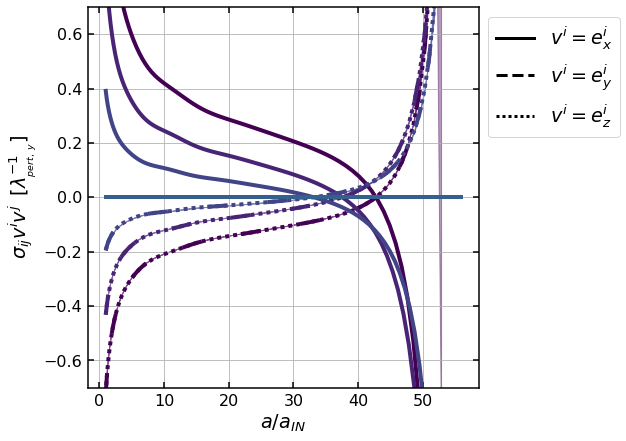

In [7]:
plt.figure(figsize=(7, 7))
alphafac = 0.4
sims32 = ['pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N32_LCDM','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D50sde_TV']
sims64 = ['pflrw_d3e2_L1821_t1_N64_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N64_LCDM','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N64_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N64_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D50sde_TV']
sims128 = ['pflrw_d3e2_L1821_t1_N128_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N128_LCDM','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N128_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N128_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D50sde_TV']

colors = plt.cm.viridis(np.linspace(0, 1, len(sims128)))
i = 0
for s32, s64, s128, c in zip(sims32, sims64, sims128, colors):
    if i > 3:
        pass
    else:
        p32 = RRead.read_parameters(s32)
        p64 = RRead.read_parameters(s64)
        p128 = RRead.read_parameters(s128)
        Ly = p128['Ly']
        Lin = LinData.LinData_Class(p128)
        d32 = pd.read_table(p32['datapath']+'shear_deformOD.csv', delimiter=',')
        d64 = pd.read_table(p64['datapath']+'shear_deformOD.csv', delimiter=',')
        d128 = pd.read_table(p128['datapath']+'shear_deformOD.csv', delimiter=',')
        an = [Lin.an_initial(Lin.temp_from_temp('t', 'it', it)) for it in d128['it']]
        plt.plot(an, d128['shearonxOD']*Ly, color = c, linestyle = '-', linewidth=4)
        plt.plot(an, d128['shearonyOD']*Ly, color = c, linestyle = (0, (5, 10)), linewidth=4)
        plt.plot(an, d128['shearonzOD']*Ly, color = c, linestyle = (0, (1, 1)), linewidth=4)

        err = get_error(d32['shearonxOD']*Ly, d64['shearonxOD']*Ly, d128['shearonxOD']*Ly)
        plt.fill_between(an, d128['shearonxOD']*Ly-err, d128['shearonxOD']*Ly+err, color=c, alpha=alphafac)
        err = get_error(d32['shearonyOD']*Ly, d64['shearonyOD']*Ly, d128['shearonyOD']*Ly)
        plt.fill_between(an, d128['shearonyOD']*Ly-err, d128['shearonyOD']*Ly+err, color=c, alpha=alphafac)
        err = get_error(d32['shearonzOD']*Ly, d64['shearonzOD']*Ly, d128['shearonzOD']*Ly)
        plt.fill_between(an, d128['shearonzOD']*Ly-err, d128['shearonzOD']*Ly+err, color=c, alpha=alphafac)
    i +=1
    
plt.plot(an, d128['shearonxOD']*0+100, color = 'k', linestyle = '-', label=r'$v^{i}=e_{x}^{i}$')
plt.plot(an, d128['shearonyOD']*0+100, color = 'k', linestyle = '--', label=r'$v^{i}=e_{y}^{i}$')
plt.plot(an, d128['shearonzOD']*0+100, color = 'k', linestyle = (0, (1, 1)), label=r'$v^{i}=e_{z}^{i}$')
plt.grid()
plt.ylabel(r'$\sigma_{ij} v^{i} v^{j} \;\; [\lambda_{{}_{pert, \; y}}^{-1}]$')
plt.xlabel(r'$a/a_{IN}$')
plt.legend(bbox_to_anchor=(1,1))
#plt.xlim(15, 30)
plt.ylim(-0.7, 0.7)

 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file


(-0.7, 0.7)

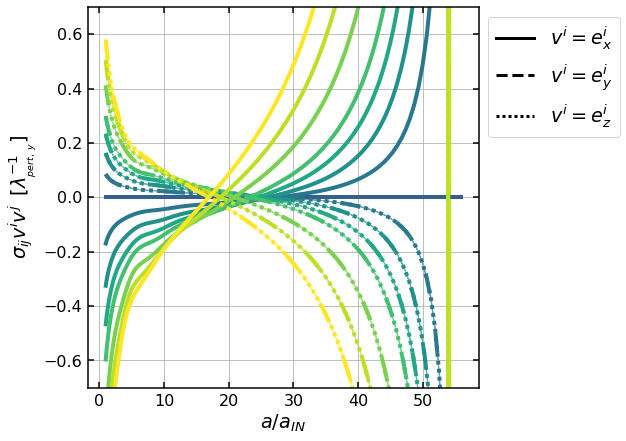

In [8]:
plt.figure(figsize=(7, 7))
alphafac = 0.4
sims32 = ['pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N32_LCDM','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D50sde_TV']
sims64 = ['pflrw_d3e2_L1821_t1_N64_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N64_LCDM','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N64_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N64_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D50sde_TV']
sims128 = ['pflrw_d3e2_L1821_t1_N128_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N128_LCDM','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N128_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N128_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D50sde_TV']

colors = plt.cm.viridis(np.linspace(0, 1, len(sims128)))
i = 0
for s32, s64, s128, c in zip(sims32, sims64, sims128, colors):
    if i<3:
        pass
    else:
        p32 = RRead.read_parameters(s32)
        p64 = RRead.read_parameters(s64)
        p128 = RRead.read_parameters(s128)
        Ly = p128['Ly']
        Lin = LinData.LinData_Class(p128)
        d32 = pd.read_table(p32['datapath']+'shear_deformOD.csv', delimiter=',')
        d64 = pd.read_table(p64['datapath']+'shear_deformOD.csv', delimiter=',')
        d128 = pd.read_table(p128['datapath']+'shear_deformOD.csv', delimiter=',')
        an = [Lin.an_initial(Lin.temp_from_temp('t', 'it', it)) for it in d128['it']]
        plt.plot(an, d128['shearonxOD']*Ly, color = c, linestyle = '-', linewidth=4)
        plt.plot(an, d128['shearonyOD']*Ly, color = c, linestyle = (0, (5, 10)), linewidth=4)
        plt.plot(an, d128['shearonzOD']*Ly, color = c, linestyle = (0, (1, 1)), linewidth=4)

        err = get_error(d32['shearonxOD']*Ly, d64['shearonxOD']*Ly, d128['shearonxOD']*Ly)
        plt.fill_between(an, d128['shearonxOD']*Ly-err, d128['shearonxOD']*Ly+err, color=c, alpha=alphafac)
        err = get_error(d32['shearonyOD']*Ly, d64['shearonyOD']*Ly, d128['shearonyOD']*Ly)
        plt.fill_between(an, d128['shearonyOD']*Ly-err, d128['shearonyOD']*Ly+err, color=c, alpha=alphafac)
        err = get_error(d32['shearonzOD']*Ly, d64['shearonzOD']*Ly, d128['shearonzOD']*Ly)
        plt.fill_between(an, d128['shearonzOD']*Ly-err, d128['shearonzOD']*Ly+err, color=c, alpha=alphafac)
    i += 1
    
plt.plot(an, d128['shearonxOD']*0+100, color = 'k', linestyle = '-', label=r'$v^{i}=e_{x}^{i}$')
plt.plot(an, d128['shearonyOD']*0+100, color = 'k', linestyle = '--', label=r'$v^{i}=e_{y}^{i}$')
plt.plot(an, d128['shearonzOD']*0+100, color = 'k', linestyle = (0, (1, 1)), label=r'$v^{i}=e_{z}^{i}$')
plt.grid()
plt.ylabel(r'$\sigma_{ij} v^{i} v^{j} \;\; [\lambda_{{}_{pert, \; y}}^{-1}]$')
plt.xlabel(r'$a/a_{IN}$')
plt.legend(bbox_to_anchor=(1,1))
#plt.xlim(15, 30)
plt.ylim(-0.7, 0.7)

In [26]:
colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.282623, 0.140926, 0.457517, 1.      ],
       [0.253935, 0.265254, 0.529983, 1.      ],
       [0.206756, 0.371758, 0.553117, 1.      ],
       [0.163625, 0.471133, 0.558148, 1.      ],
       [0.127568, 0.566949, 0.550556, 1.      ],
       [0.134692, 0.658636, 0.517649, 1.      ],
       [0.266941, 0.748751, 0.440573, 1.      ],
       [0.477504, 0.821444, 0.318195, 1.      ],
       [0.741388, 0.873449, 0.149561, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

In [30]:
Leqid = 3
sims32[:Leqid+1]+sims32[Leqid:]

['pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30bde_TV',
 'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20bde_TV',
 'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10bde_TV',
 'pflrw_d3e2_L1821_t1_N32_LCDM',
 'pflrw_d3e2_L1821_t1_N32_LCDM',
 'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D5sde_TV',
 'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10sde_TV',
 'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D15sde_TV',
 'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20sde_TV',
 'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30sde_TV',
 'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D40sde_TV',
 'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D50sde_TV']

 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file


Text(0.5, 0, '$a/a_{IN}$')

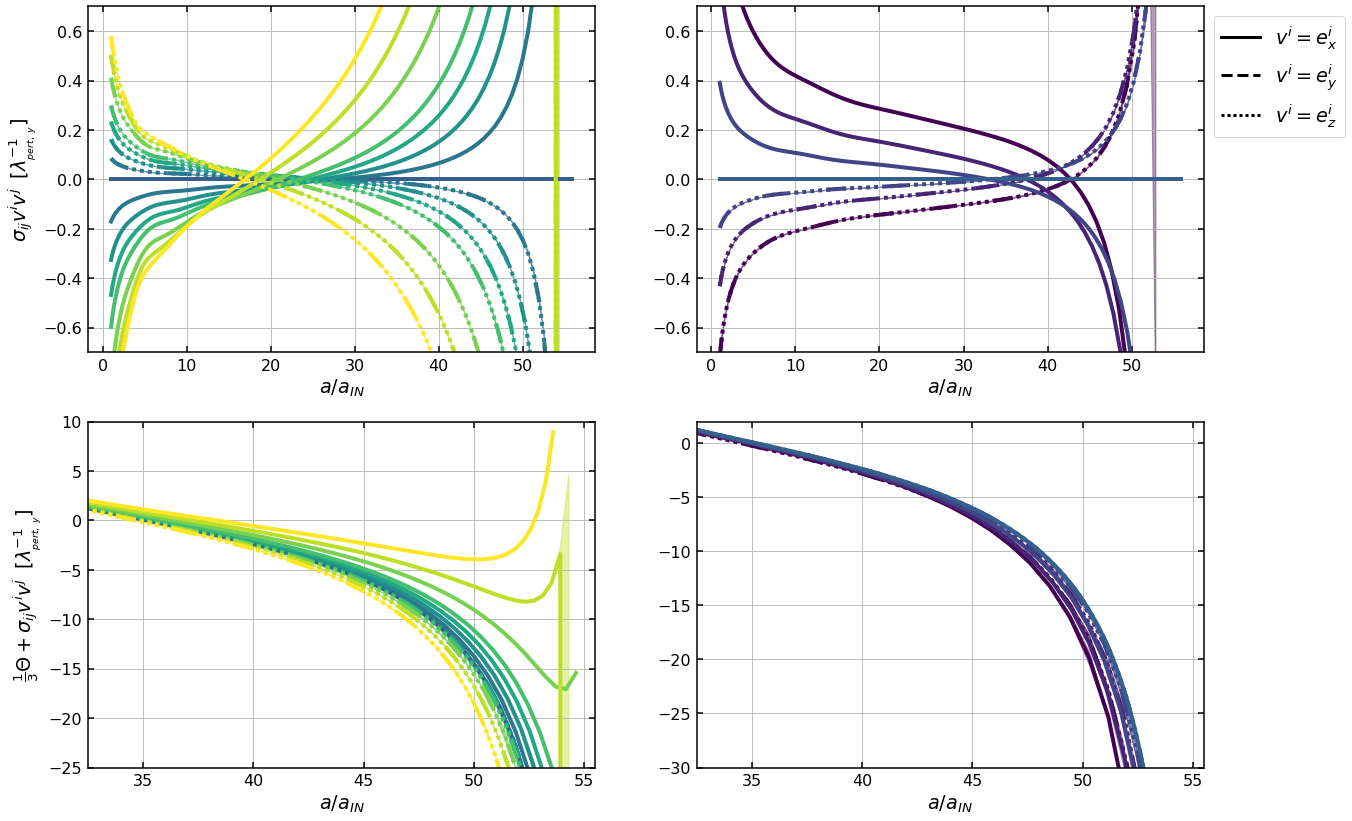

In [37]:
plt.figure(figsize=(20, 14))
axA = plt.subplot(221)
axB = plt.subplot(222)
axC = plt.subplot(223)
axD = plt.subplot(224)
alphafac = 0.4
sims32 = ['pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N32_LCDM','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D50sde_TV']
Leqid = 3
sims64 = ['pflrw_d3e2_L1821_t1_N64_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N64_LCDM','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N64_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N64_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D50sde_TV']
sims128 = ['pflrw_d3e2_L1821_t1_N128_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N128_LCDM','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N128_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N128_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D50sde_TV']

colors = plt.cm.viridis(np.linspace(0, 1, len(sims128)))

sims32 = sims32[:Leqid+1] + sims32[Leqid:]
sims64 = sims64[:Leqid+1] + sims64[Leqid:]
sims128 = sims128[:Leqid+1] + sims128[Leqid:]
colors = np.append(colors[:Leqid+1], colors[Leqid:], axis=0)

i = 0
for s32, s64, s128, c in zip(sims32, sims64, sims128, colors):
    if i>Leqid:
        ax1 = axA
        ax2 = axC
    else:
        ax1 = axB
        ax2 = axD
    p32 = RRead.read_parameters(s32)
    p64 = RRead.read_parameters(s64)
    p128 = RRead.read_parameters(s128)
    Ly = p128['Ly']
    Lin = LinData.LinData_Class(p128)
    d32 = pd.read_table(p32['datapath']+'shear_deformOD.csv', delimiter=',')
    d64 = pd.read_table(p64['datapath']+'shear_deformOD.csv', delimiter=',')
    d128 = pd.read_table(p128['datapath']+'shear_deformOD.csv', delimiter=',')
    an = [Lin.an_initial(Lin.temp_from_temp('t', 'it', it)) for it in d128['it']]
    ax1.plot(an, d128['shearonxOD']*Ly, color = c, linestyle = '-', linewidth=4)
    ax1.plot(an, d128['shearonyOD']*Ly, color = c, linestyle = (0, (5, 10)), linewidth=4)
    ax1.plot(an, d128['shearonzOD']*Ly, color = c, linestyle = (0, (1, 1)), linewidth=4)
    
    err = get_error(d32['shearonxOD']*Ly, d64['shearonxOD']*Ly, d128['shearonxOD']*Ly)
    ax1.fill_between(an, d128['shearonxOD']*Ly-err, d128['shearonxOD']*Ly+err, color=c, alpha=alphafac)
    err = get_error(d32['shearonyOD']*Ly, d64['shearonyOD']*Ly, d128['shearonyOD']*Ly)
    ax1.fill_between(an, d128['shearonyOD']*Ly-err, d128['shearonyOD']*Ly+err, color=c, alpha=alphafac)
    err = get_error(d32['shearonzOD']*Ly, d64['shearonzOD']*Ly, d128['shearonzOD']*Ly)
    ax1.fill_between(an, d128['shearonzOD']*Ly-err, d128['shearonzOD']*Ly+err, color=c, alpha=alphafac)
    
    Theta32 = -pd.read_table(p32['datapath']+'h5_data.csv', delimiter=',')['K_OD']
    Theta64 = -pd.read_table(p64['datapath']+'h5_data.csv', delimiter=',')['K_OD']
    Theta128 = -pd.read_table(p128['datapath']+'h5_data.csv', delimiter=',')['K_OD']
    ax2.plot(an, ((Theta128/3) + d128['shearonxOD'])*Ly, color = c, linestyle = '-', linewidth=4)
    ax2.plot(an, ((Theta128/3) + d128['shearonyOD'])*Ly, color = c, linestyle = (0, (5, 10)), linewidth=4)
    ax2.plot(an, ((Theta128/3) + d128['shearonzOD'])*Ly, color = c, linestyle = (0, (1, 1)), linewidth=4)
    
    err = get_error(((Theta32/3) + d32['shearonxOD'])*Ly, 
                     ((Theta64/3) + d64['shearonxOD'])*Ly, 
                      ((Theta128/3) + d128['shearonxOD'])*Ly)
    ax2.fill_between(an, ((Theta128/3) + d128['shearonxOD'])*Ly-err, 
                          ((Theta128/3) + d128['shearonxOD'])*Ly+err, color=c, alpha=alphafac)
    err = get_error(((Theta32/3) + d32['shearonyOD'])*Ly,
                     ((Theta64/3) + d64['shearonyOD'])*Ly, 
                      ((Theta128/3) + d128['shearonyOD'])*Ly)
    ax2.fill_between(an, ((Theta128/3) + d128['shearonyOD'])*Ly-err, 
                          ((Theta128/3) + d128['shearonyOD'])*Ly+err, color=c, alpha=alphafac)
    err = get_error(((Theta32/3) + d32['shearonzOD'])*Ly, 
                     ((Theta64/3) + d64['shearonzOD'])*Ly, 
                      ((Theta128/3) + d128['shearonzOD'])*Ly)
    ax2.fill_between(an, ((Theta128/3) + d128['shearonzOD'])*Ly-err, 
                          ((Theta128/3) + d128['shearonzOD'])*Ly+err, color=c, alpha=alphafac)
    i+=1
    
axA.grid()
axA.set_ylabel(r'$\sigma_{ij} v^{i} v^{j} \;\; [\lambda_{{}_{pert, \; y}}^{-1}]$')
axA.set_xlabel(r'$a/a_{IN}$')
axA.set_ylim(-0.7, 0.7)
axB.plot(an, d128['shearonxOD']*0+100, color = 'k', linestyle = '-', label=r'$v^{i}=e_{x}^{i}$')
axB.plot(an, d128['shearonyOD']*0+100, color = 'k', linestyle = '--', label=r'$v^{i}=e_{y}^{i}$')
axB.plot(an, d128['shearonzOD']*0+100, color = 'k', linestyle = (0, (1, 1)), label=r'$v^{i}=e_{z}^{i}$')
axB.grid()
axB.set_xlabel(r'$a/a_{IN}$')
axB.legend(bbox_to_anchor=(1,1))
axB.set_ylim(-0.7, 0.7)

axC.set_ylim(-25, 10)
axC.set_xlim(32.5, 55.5)
axC.grid()
axC.set_ylabel(r'$\frac{1}{3}\Theta + \sigma_{ij} v^{i} v^{j} \;\; [\lambda_{{}_{pert, \; y}}^{-1}]$')
axC.set_xlabel(r'$a/a_{IN}$')
axD.set_ylim(-30, 2)
axD.set_xlim(32.5, 55.5)
axD.grid()
axD.set_xlabel(r'$a/a_{IN}$')

 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file
 read time file


(8.0, 56.0)

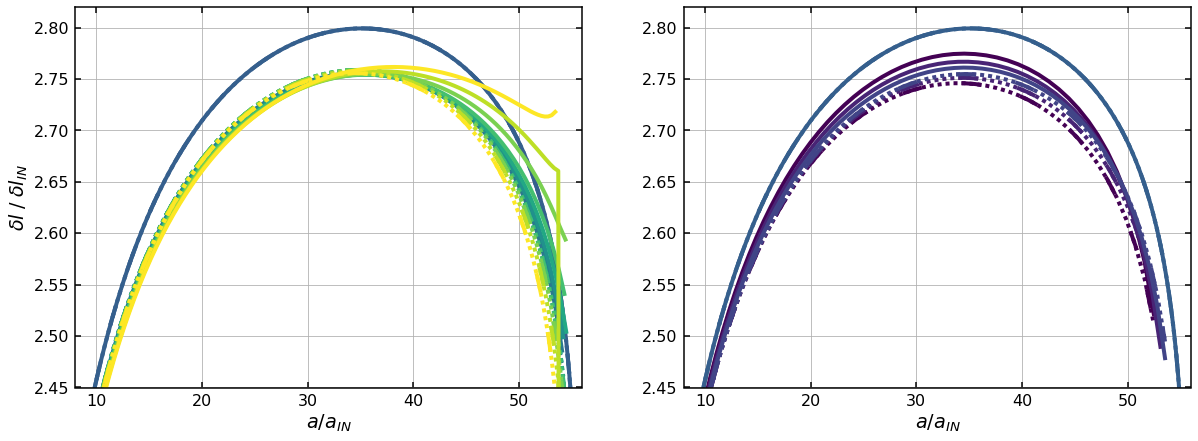

In [38]:
plt.figure(figsize=(20, 7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
alphafac = 0.4
sims32 = ['pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N32_LCDM','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N32_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N32_LCDM_Q1D50sde_TV']
Leqid = 3
sims64 = ['pflrw_d3e2_L1821_t1_N64_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N64_LCDM','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N64_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N64_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N64_LCDM_Q1D50sde_TV']
sims128 = ['pflrw_d3e2_L1821_t1_N128_LCDM_Q1D30bde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D20bde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D10bde_TV',
          'pflrw_d3e2_L1821_t1_N128_LCDM','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D5sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D10sde_TV',
        'pflrw_d3e2_L1821_t1_N128_LCDM_Q1D15sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D20sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D30sde_TV',
        'pflrw_d3e2_L1821_t1_N128_LCDM_Q1D40sde_TV','pflrw_d3e2_L1821_t1_N128_LCDM_Q1D50sde_TV']

colors = plt.cm.viridis(np.linspace(0, 1, len(sims128)))

sims32 = sims32[:Leqid+1] + sims32[Leqid:]
sims64 = sims64[:Leqid+1] + sims64[Leqid:]
sims128 = sims128[:Leqid+1] + sims128[Leqid:]
colors = np.append(colors[:Leqid+1], colors[Leqid:], axis=0)

j = 0
for s32, s64, s128, c in zip(sims32, sims64, sims128, colors):
    if j>Leqid:
        ax = ax1
    else:
        ax = ax2
    p32 = RRead.read_parameters(s32)
    p64 = RRead.read_parameters(s64)
    p128 = RRead.read_parameters(s128)
    Ly = p128['Ly']
    Lin = LinData.LinData_Class(p128)
    Theta32 = -pd.read_table(p32['datapath']+'h5_data.csv', delimiter=',')['K_OD']
    Theta64 = -pd.read_table(p64['datapath']+'h5_data.csv', delimiter=',')['K_OD']
    Theta128 = -pd.read_table(p128['datapath']+'h5_data.csv', delimiter=',')['K_OD']
    d32 = pd.read_table(p32['datapath']+'shear_deformOD.csv', delimiter=',')
    d64 = pd.read_table(p64['datapath']+'shear_deformOD.csv', delimiter=',')
    d128 = pd.read_table(p128['datapath']+'shear_deformOD.csv', delimiter=',')
    an = [Lin.an_initial(Lin.temp_from_temp('t', 'it', it)) for it in d128['it']]
    
    Dx = [1.0]
    Dy = [1.0]
    Dz = [1.0]
    anint = [1.0]
    fx = (Theta128/3) + d128['shearonxOD']
    fy = (Theta128/3) + d128['shearonyOD']
    fz = (Theta128/3) + d128['shearonzOD']
    for i in range(len(an)-1):
        dt = an[i+1] - an[i]
        anint += [(an[i+1] + an[i])/2]
        Dx += [Dx[i] * np.exp(dt *(fx[i] + fx[i+1])/2)]
        Dy += [Dy[i] * np.exp(dt *(fy[i] + fy[i+1])/2)]
        Dz += [Dz[i] * np.exp(dt *(fz[i] + fz[i+1])/2)]
    
    ax.plot(anint, Dx, color = c, linestyle = '-', linewidth=4)
    ax.plot(anint, Dy, color = c, linestyle = (0, (5, 10)), linewidth=4)
    ax.plot(anint, Dz, color = c, linestyle = (0, (1, 1)), linewidth=4)
    j += 1
    
ax1.grid()
ax1.set_xlabel(r'$a/a_{IN}$')
ax1.set_ylabel(r'$\delta l \;/\; \delta l_{IN}$')
ax1.set_ylim(2.45, 2.82)
ax1.set_xlim(8, 56)

ax2.grid()
ax2.set_xlabel(r'$a/a_{IN}$')
ax2.set_ylim(2.45, 2.82)
ax2.set_xlim(8, 56)